# Modelos para pronóstico de cuenta corriente (de series de tiempo y de ciencia de datos)

Debido a que los indicadores que componen la cuenta corriente se encuentran en constante revisión, las cuales pueden ser considerables, es necesario guardar las diferentes versiones con las que se corren los modelos para pronosticarla.

### Paso 1. Descargar la versión más reciente de la cuenta corriente de Banco de México

In [317]:
import sys
import numpy as np
import pandas as pd
from fun_descarga import *
import matplotlib.pyplot as plt
import statsmodels
import os

os.chdir('/Users/1thaliaespana1/Documents/Semestre II/ambientes/sandbox_Python/estancia_investigacion/modelacion_economica')

In [685]:
fecha_inicio='2002-01-01'
fecha_fin='2023-07-01'

corr=descargar_banxico('SE44352',fecha_inicio,fecha_fin)
corr_credito=descargar_banxico('SE44353,SE44354,SE44357,SE44363,SE44369',fecha_inicio,fecha_fin)
corr_debito=descargar_banxico('SE44372,SE44373,SE44376,SE44382,SE44390',fecha_inicio,fecha_fin)
cap=descargar_banxico('SE44393,SE44394,SE44395',fecha_inicio,fecha_fin)

In [686]:
#para guardar las versiones de cuenta corriente
df1=pd.DataFrame(pd.concat([corr,corr_credito,corr_debito,cap],axis=1))
df1.to_csv('/Users/1thaliaespana1/Documents/Semestre II/ambientes/sandbox_Python/estancia_investigacion/modelacion_economica/versiones_balanza_pagos/balanza_pagos_230913.csv', index=True, header=True)

In [262]:
#función que acorta los títulos específicos de balanza de pagos

def limpiar_titulo(c_corr_credito):
    for k,v in c_corr_credito.items():
        nueva=k.split("(a partir de 2002)")[1]
        c_corr_credito[nueva]=c_corr_credito.pop(k)
    return c_corr_credito
corr_credito=limpiar_titulo(corr_credito)
corr_debito=limpiar_titulo(corr_debito)
corr=limpiar_titulo(corr)
cap=limpiar_titulo(cap)



In [263]:

#Cambiar nombres de columnas
corr.rename(columns={'Cuenta corriente (I - II)':'corr'},inplace=True)
corr_credito.rename(columns={'Cuenta corriente (I - II) I. Crédito (A + B + C + D) D. Ingreso secundario':'corr_cred_ingsec',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D) C. Ingreso primario':'corr_cred_ingprim',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D) B. Servicios 2/':'corr_cred_serv',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D) A. Bienes':'corr_cred_bien',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D)':'corr_cred',},inplace=True)
cap.rename(columns={'Cuenta de capital (I - II) II. Débito':'cap_deb',
'Cuenta de capital (I - II) I.Crédito':'cap_cred',
'Cuenta de capital (I - II)':'cap',},inplace=True)
corr_debito.rename(columns={'Cuenta corriente (I - II) II. Débito (A + B + C + D) C. Ingreso primario':'corr_deb_ingprim',
'Cuenta corriente (I - II) II. Débito (A + B + C + D) A. Bienes':'corr_deb_bien',
'Cuenta corriente (I - II) II. Débito (A + B + C + D) B. Servicios 2/':'corr_deb_serv',
'Cuenta corriente (I - II) II. Débito (A + B + C + D) D. Ingreso secundario':'corr_deb_ingsec',
'Cuenta corriente (I - II) II. Débito (A + B + C + D)':'corr_deb_deb'},inplace=True)


## Análisis exploratorio de datos

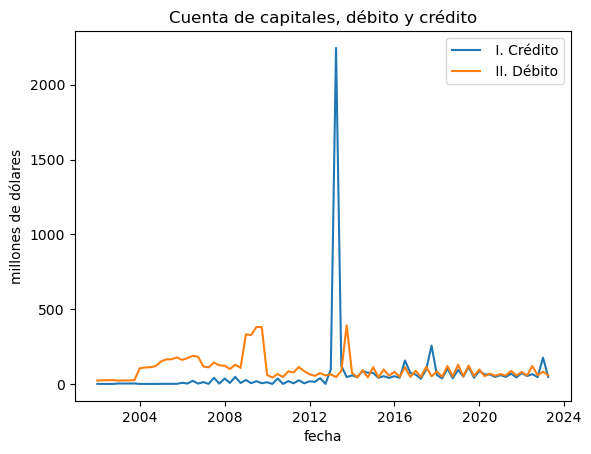

In [730]:
titulo3=[i.split('(I - II)', 1)[1] for i in cap.keys()]

x0=pd.to_datetime(list(cap.index),format="%d/%m/%Y")
y30=cap.iloc[:,1]
y31=cap.iloc[:,2]
plt.plot(x0,y30,x0,y31)
plt.xlabel('fecha')
plt.ylabel('millones de dólares')
plt.title('Cuenta de capitales, débito y crédito')
plt.legend([titulo3[1],titulo3[2]])

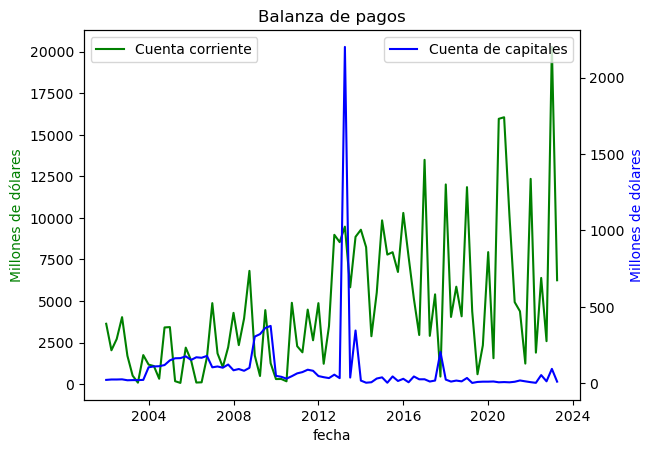

In [712]:
x0=pd.to_datetime(list(corr.index),format="%d/%m/%Y")
y00=corr.iloc[:,0]
y01=cap.iloc[:,0]

fig, ax0 = plt.subplots()

ax1 = ax0.twinx()
ax0.plot(x0, y00, 'g-')
ax1.plot(x0, y01, 'b-')

ax0.set_xlabel('fecha')
ax0.set_ylabel('Millones de dólares', color='g')
ax1.set_ylabel('Millones de dólares', color='b')

plt.title('Balanza de pagos')
ax0.legend(['Cuenta corriente'])
ax1.legend(['Cuenta de capitales'])

plt.show()

### Cuenta corriente. Crédito

Se observa que la cuenta de crédito de cuenta corriente más grande proviene de la cuenta de bienes, la cual comprenden exportaciones de mercancías y asciende a más de 175 mil millones de pesos. Por su parte, la segunda cuenta más grande (aunque considerablemente más chica que la cuenta de bienes) es la cuenta de ingresos secundarios, los cuales son casi su totalidad ingresos por remesas y ascienden a poco menos de 23 mil millones de pesos. 

Por su parte, la cuenta de servicios primarios de crédito comprende utilidades, dividendos, intereses y remuneración de empleados, y ascendió a poco menos de 23 mil millones de pesos. Por otro lado, las de servicios suman transporte, viajes, servicios empresariales, propiedad intelectual entre los más importantes. 

No obstante, en saldos netos (débito - crédito) la cuenta corriente de bienes, servicios e ingresos primarios se encuentra en saldos positivos, mientras que sólo la cuenta de ingresos secundarios se encuentra en saldos negativos. Por otro lado, se observa un poco de estacionalidad en las cuentas de ingresos primarios e ingresos secundarios.

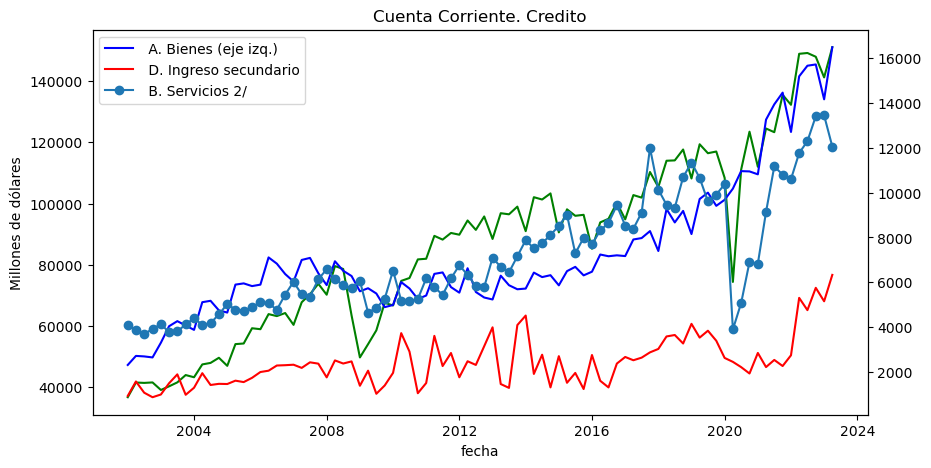

In [752]:
titulo1=[i.split('(A + B + C + D)', 1)[1] for i in c_corr_credito.keys()]

x1=pd.to_datetime(list(corr_credito.index),format="%d/%m/%Y")
y10=corr_credito.iloc[:,0]
y11=corr_credito.iloc[:,1]
y12=corr_credito.iloc[:,2]
y13=corr_credito.iloc[:,3]
y14=corr_credito.iloc[:,4]

fig, ax0 = plt.subplots(figsize=(10, 5))

ax1 = ax0.twinx()
ax0.plot(x1, y11, 'g-')
ax1.plot(x1, y10, 'b-')
ax1.plot(x1, y12, 'r-')
ax1.plot(x1, y13, 'o-')

ax0.set_xlabel('fecha')
ax0.set_ylabel('Millones de dólares')
plt.title('Cuenta Corriente. Credito')
plt.legend([titulo1[0]+' (eje izq.)',titulo1[1],titulo1[2],titulo1[3]],loc='upper left')

plt.show()

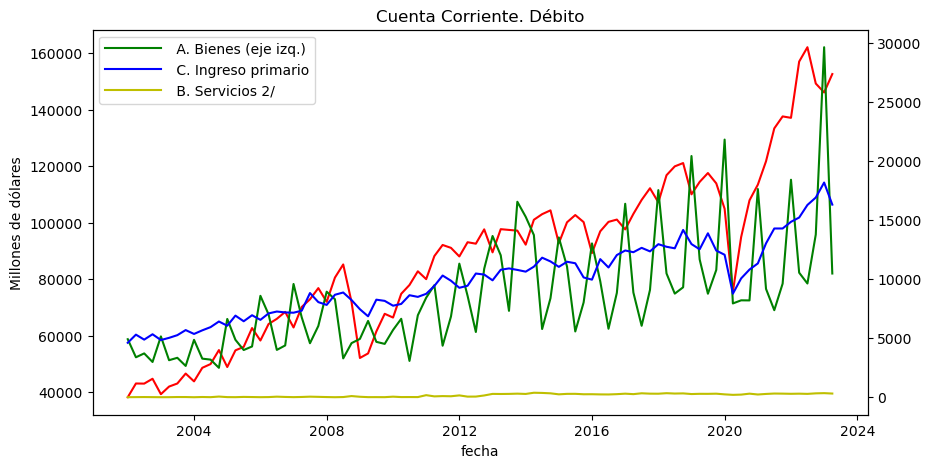

In [742]:

titulo2=[i.split('(A + B + C + D)', 1)[1] for i in corr_debito.keys()]

x2=pd.to_datetime(list(corr_debito.index),format="%d/%m/%Y")
y20=corr_debito.iloc[:,0]
y21=corr_debito.iloc[:,1]
y22=corr_debito.iloc[:,2]
y23=corr_debito.iloc[:,3]
y24=corr_debito.iloc[:,4]


fig, ax0 = plt.subplots(figsize=(10, 5))

ax1 = ax0.twinx()
ax0.plot(x1, y22,'r')
ax1.plot(x1, y20,'g')
ax1.plot(x1, y23,'b')
ax1.plot(x1, y24,'y')

ax0.set_xlabel('fecha')
ax0.set_ylabel('Millones de dólares')
plt.title('Cuenta Corriente. Débito')
plt.legend([titulo2[2]+' (eje izq.)',titulo2[0],titulo2[3],titulo2[4]],loc='upper left',handlelength=4)


plt.show()

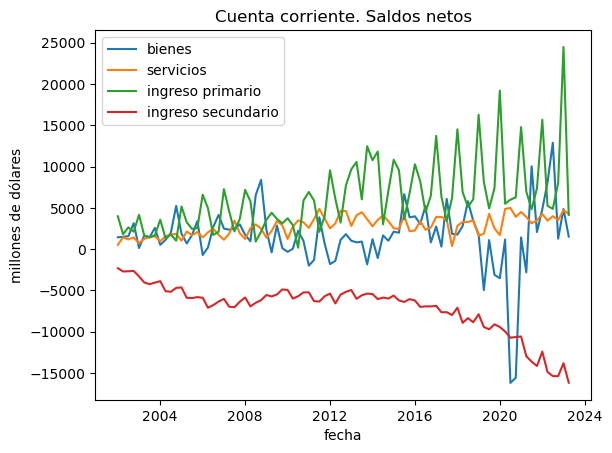

In [751]:
corr_neto_ingsec=corr_debito.iloc[:,4]-corr_credito.iloc[:,0]
corr_neto_serv=corr_debito.iloc[:,3]-corr_credito.iloc[:,3]
corr_neto_ingprim=corr_debito.iloc[:,0]-corr_credito.iloc[:,2]
corr_neto_bienes=corr_debito.iloc[:,2]-corr_credito.iloc[:,1]
plt.plot(x2,corr_neto_bienes,x2,corr_neto_serv,x2,corr_neto_ingprim,x2,corr_neto_ingsec)
plt.xlabel('fecha')
plt.ylabel('millones de dólares')
plt.title('Cuenta corriente. Saldos netos')
plt.legend(['bienes','servicios','ingreso primario','ingreso secundario'])


### 2. Selección de variables explicativas

Dado que en la cuenta de crédito los bienes fueron la subcuenta más grande con 178 mil millones de dólares, se revisó el análisis de exportaciones e importaciones del [atlas de Harvard](https://atlas.cid.harvard.edu/countries/138/export-basket) para México. De acuerdo con dicha base de datos, las principales *exportaciones netas* para México en 2021 fueron en autos y autopartes (~28%), computadoras (~14%), petróleo (~8.3%), otros minerales (~8.5%), así como alimentos, bebidas y agropecuarios (~8%), entre otros. Por ello, se incluyó en el modelo la producción industrial de estos componentes.

Por otro lado, las cuentas de ingresos secundarios  también incluyen los ingresos por remesas, así como para la cuenta de servicios se incluyeron turismo, propiedad intelectual, que son los principales componentes.

Por todo lo anterior, se incluyeron en el modelo las siguientes variables:

* IGAE base 2013, serie original, mensual, publicada por INEGI.
* Ingresos por remesas en millones de dólares, mensual, publicada por Banco de México.
* Tipo de cambio peso-dólar promedio FIX mensual, publicada por banco de México.
* Indice de volumen de la inversión fija bruta,
* INPC general

cuadro de pronóstico de los tres meses del 2023, evaluar RMSE u otros para sep, oct, nov, dic
cuadro los criterios para evaluar 

meter datos que todavia no ocurren
guardar los pronósticos en algún lugar

no borrar los códigos de las demás

meter las redes neuronales


Destacan las siguientes características:

1. Debido a que algunas variables están en dólares y otras en pesos, se usa como control el tipo de cambio FIX promedio del periodo
2. Se decidió descargar las series originales para aplicar luego su propio proceso de desestacionalización
3. Dado que las series de balanza de pagos son trimestrales y las variables explicativas son mensuales, se realizó un nowcasting de las series de balanza de pagos

Se plantearon tres posibles modelos de predicción para cuenta corriente:

* con modelos autorregresivos tradicionales
* con modelos de redes neuronales
* con modelos de inferencia bayesianos

In [759]:

igae=descargar_banxico('SR16734',fecha_inicio,fecha_fin)
remesas=descargar_banxico('SE27803',fecha_inicio,fecha_fin)
usdmxn_mensual=descargar_banxico('SF17908',fecha_inicio,fecha_fin)
usdmxn_diaria=descargar_banxico('SF43718',fecha_inicio,fecha_fin)
ifb=descargar_banxico('SR17459',fecha_inicio,fecha_fin)
inpc=descargar_banxico('SP1',fecha_inicio,fecha_fin)

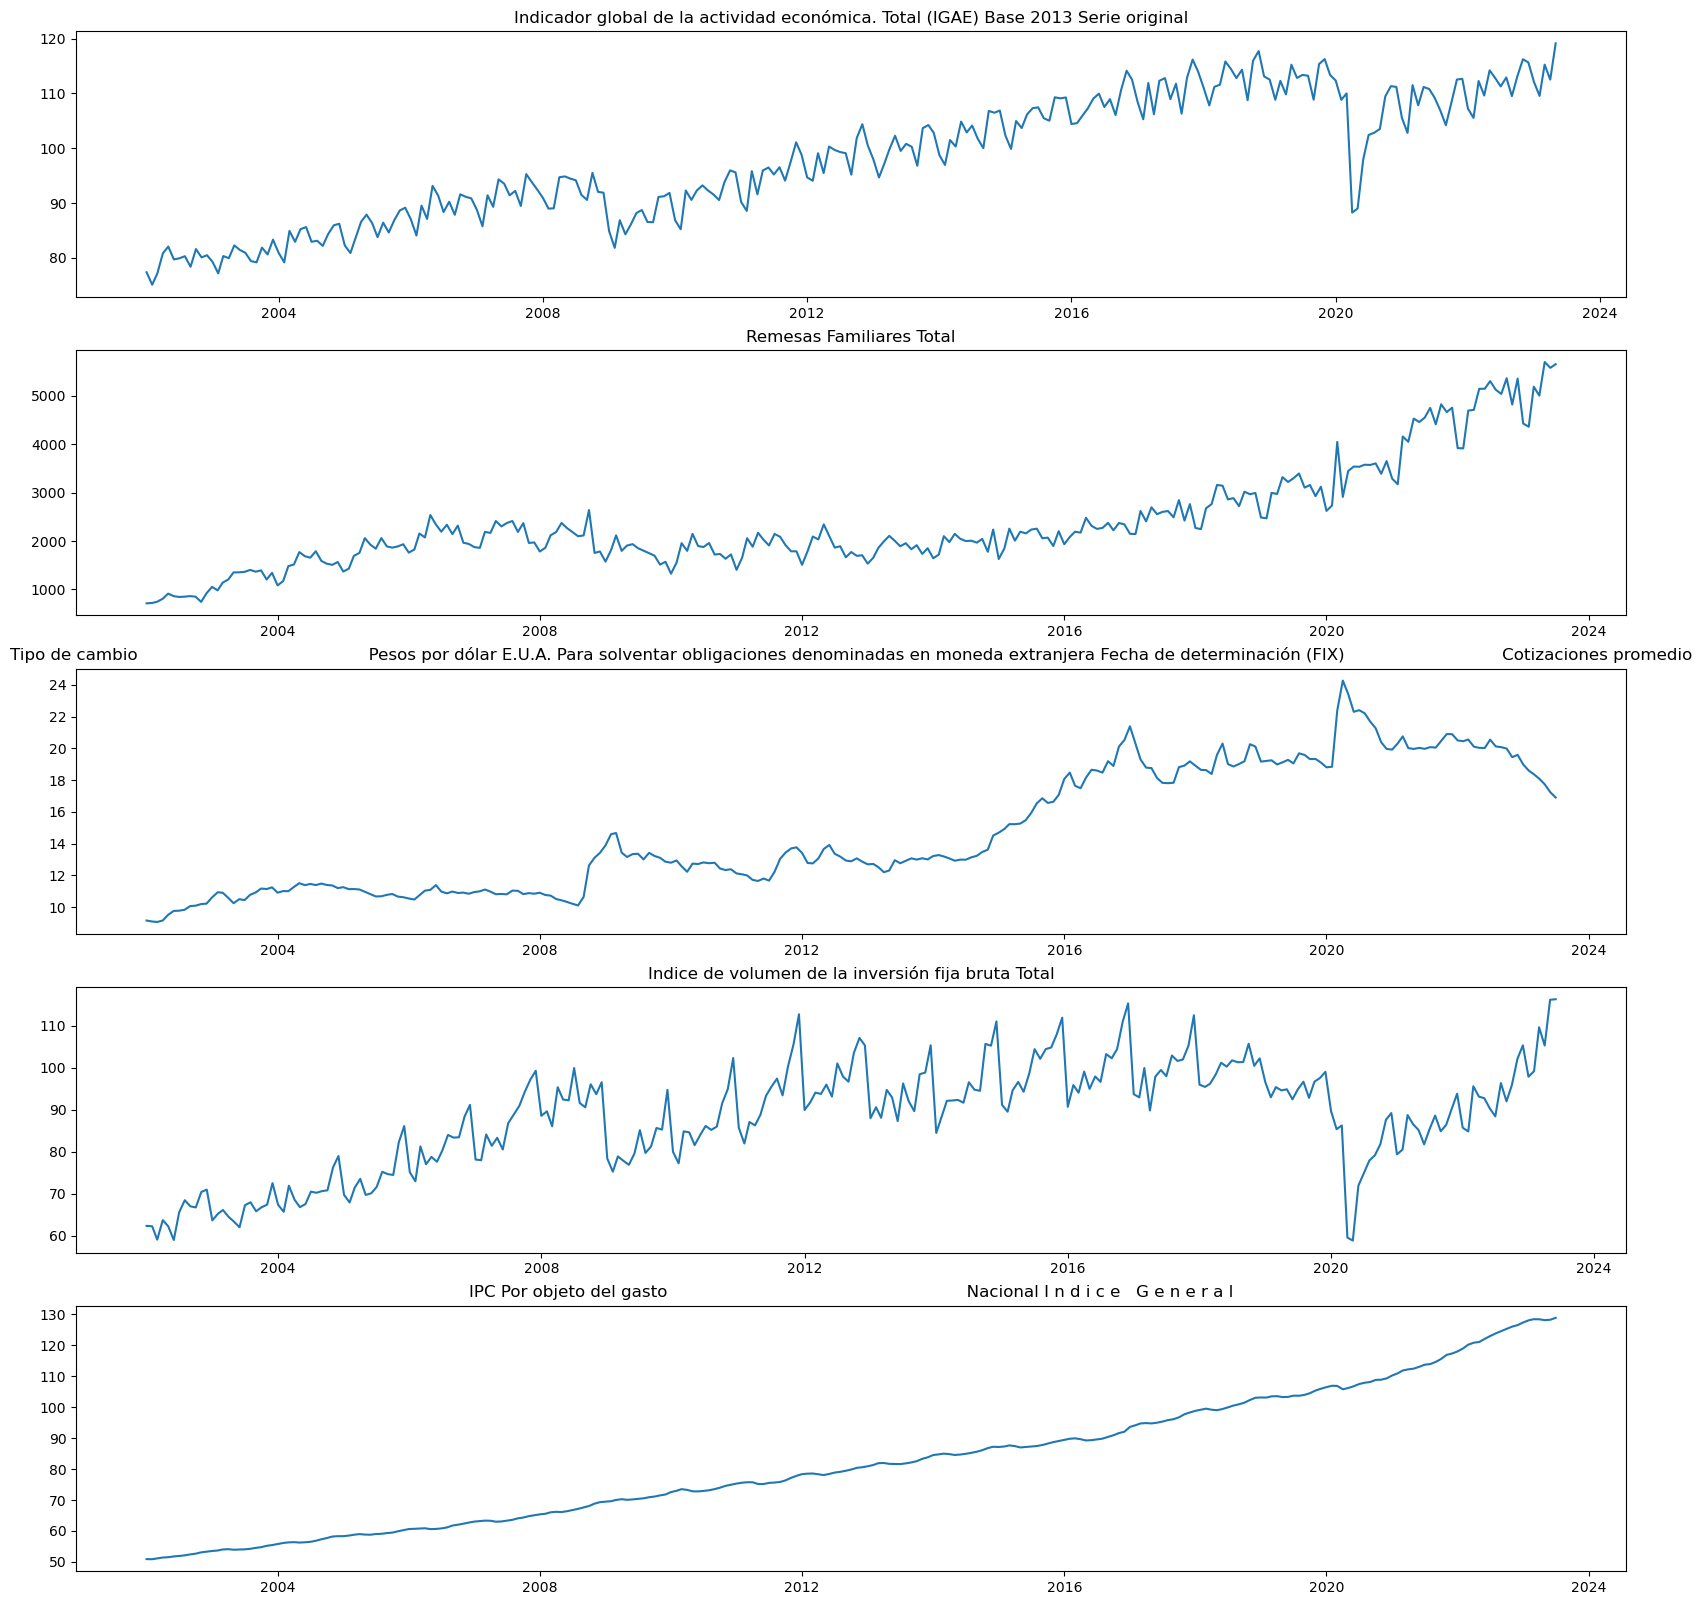

In [796]:

explicativas=pd.concat([igae,remesas,usdmxn_mensual,ifb,inpc],axis=1)
x=pd.to_datetime(list(y.index),format="%d/%m/%Y")

fig, axs = plt.subplots(5,1, figsize=(20, 20), sharey=False)

for j in range(5):
    axs[j].plot(x,explicativas.iloc[:,j])
    axs[j].set_title(explicativas.columns[j])
    
plt.show()

In [761]:
#chunk para guardar la versión de nowcast
df2=pd.DataFrame(pd.concat([explicativas,corr], axis=1))
df2.to_csv('/Users/1thaliaespana1/Documents/Semestre II/ambientes/sandbox_Python/estancia_investigacion/modelacion_economica/versiones_balanza_pagos/nowcast_bp_230918.csv', index=True, header=True)

### Auto arimas

In [818]:
#!pip install pmdarima
#!pip install torch
import pmdarima

train_set1=explicativas.iloc[:-2,:]
T1=np.shape(explicativas)[1]
#auto_arimas=train_set1.apply(lambda x:pmdarima.arima.auto_arima(x,X=train_set1.drop(x),error_action='ignore', trace=True,suppress_warnings=True, maxiter=5,seasonal=True, m=12))
auto_arimas=[]
results={}
for i in range(T1):
    yest=train_set1.iloc[:,i]
    xest=train_set1.drop(train_set1.columns[i],axis=1)
    auto_arimas.append(pmdarima.arima.auto_arima(yest,X=xest,error_action='ignore',suppress_warnings=True, maxiter=5,seasonal=True, m=12))
    results.update({'variable':,'params':auto_arimas[i].params(),'pvalues':auto_arimas[i].pvalues()})
auto_arimas

[ARIMA(maxiter=5, order=(2, 0, 1), scoring_args={}, seasonal_order=(2, 0, 1, 12),
       suppress_warnings=True, with_intercept=False),
 ARIMA(maxiter=5, order=(0, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
       suppress_warnings=True, with_intercept=False),
 ARIMA(maxiter=5, order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
       suppress_warnings=True, with_intercept=False),
 ARIMA(maxiter=5, order=(2, 0, 1), scoring_args={}, seasonal_order=(1, 0, 0, 12),
       suppress_warnings=True),
 ARIMA(maxiter=5, order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 0, 1, 12),
       suppress_warnings=True)]

In [821]:

#estimadores=pd.DataFrame(auto_arimas).apply(lambda x:x.params())
#estimadores
results


[   Remesas Familiares Total  \
 0                  0.000681   
 1                  0.545661   
 
    Tipo de cambio                                            Pesos por dólar E.U.A. Para solventar obligaciones denominadas en moneda extranjera Fecha de determinación (FIX)                              Cotizaciones promedio  \
 0                                           1.527044                                                                                                                                                                               
 1                                           0.000032                                                                                                                                                                               
 
    Indice de volumen de la inversión fija bruta Total  \
 0                                       4.248173e-01    
 1                                       1.164010e-08    
 
    IPC Por objeto del gasto         

In [648]:
fecha=pd.date_range('5/1/2022', periods = len(test_set1), freq ='m')
predicciones=predicciones.transpose().set_index([fecha])

In [649]:
from sklearn.metrics import mean_squared_error

T=np.shape(test_set1)[1]
RMSE1=[]
for i in range(T):
    RMSE1.append(mean_squared_error(test_set1.iloc[:,i],predicciones.iloc[:,i]))
RMSE1

[180.31456166153768,
 2.162399757666518,
 4.082850599889762,
 37.757258529954925,
 65.28419803574275,
 68.02082852001836,
 33329.61600624356,
 213.80298341180918,
 6.152005618444766,
 198.13514597979005]

IndexError: index 4 is out of bounds for axis 0 with size 4

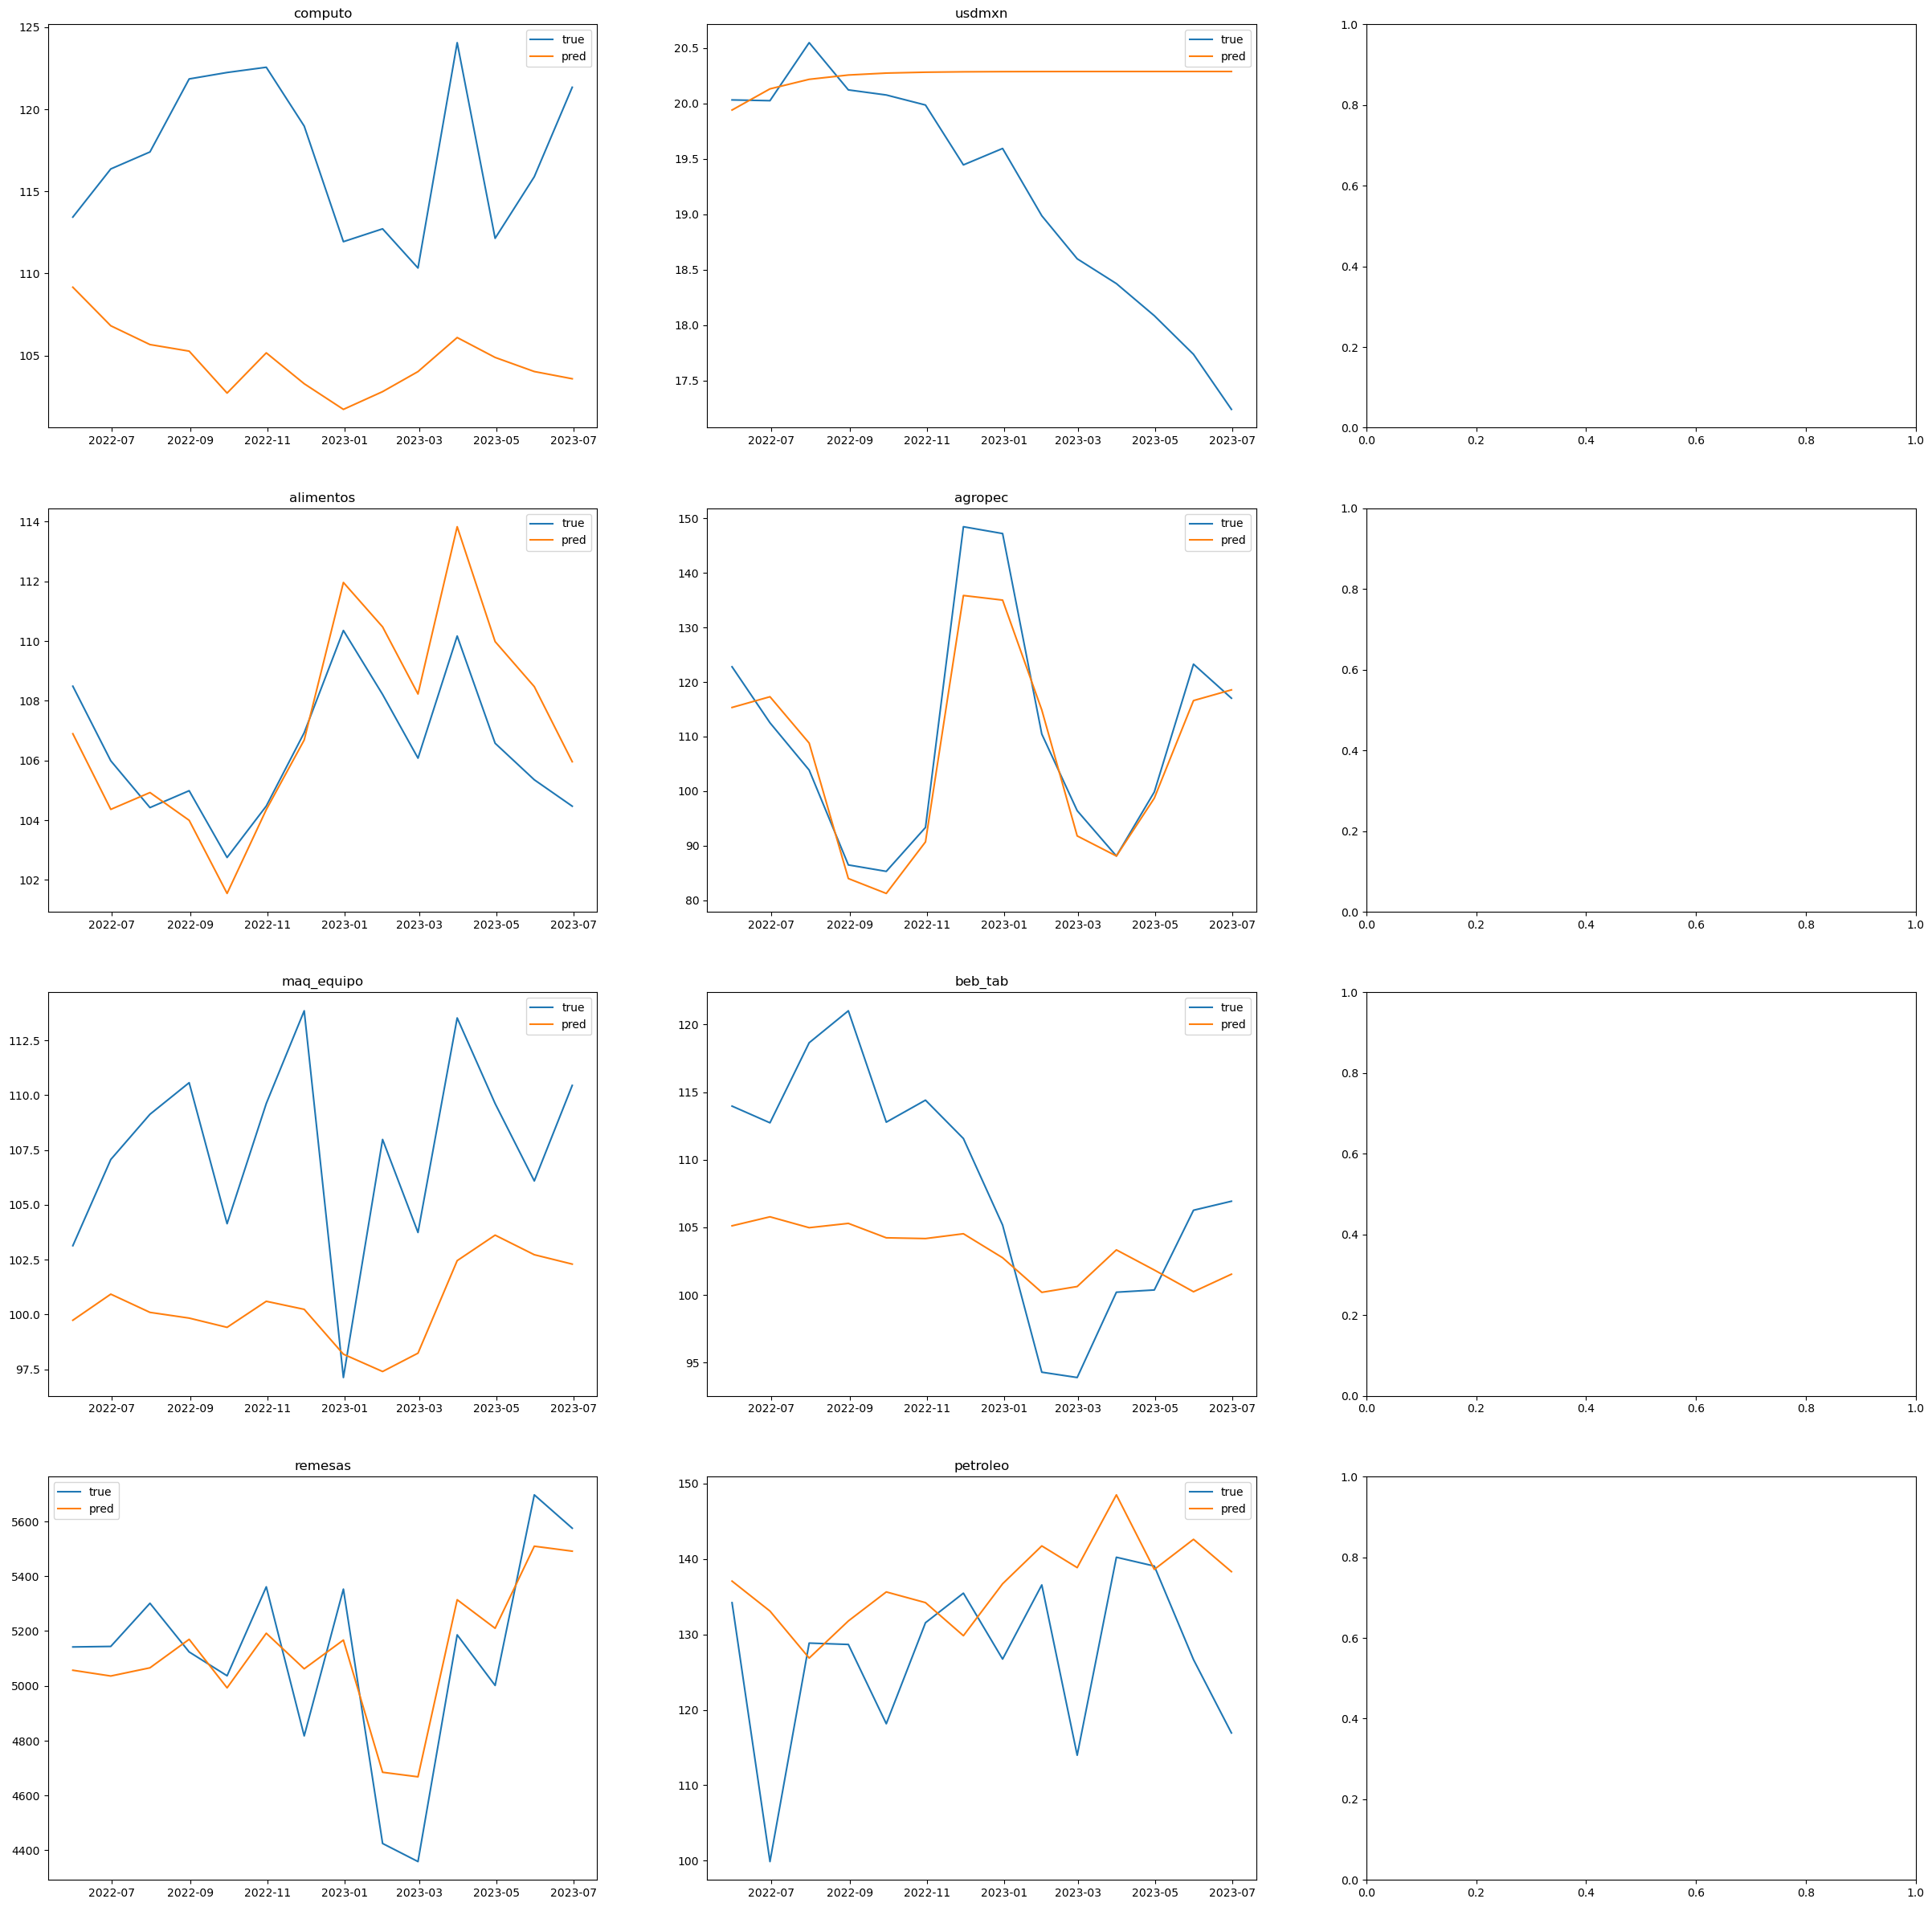

In [683]:
headers=['computo','usdmxn','alimentos','agropec','maq_equipo','beb_tab','remesas','petroleo','mineria','transporte','corriente']
k=0
fig, axs = plt.subplots(4, 3, figsize=(30, 30), sharey=False)

for i in range(5):
    for j in range(2):
        axs[i,j].plot(fecha,test_set1.iloc[:,k])
        axs[i,j].plot(fecha,predicciones.iloc[:,k])
        axs[i,j].legend(['true','pred'])
        axs[i,j].set_title(headers[k])
        k=k+1
        
plt.show()


In [677]:
headers

['computo',
 'usdmxn',
 'alimentos',
 'agropec',
 'maq_equipo',
 'beb_tab',
 'remesas',
 'petroleo',
 'mineria',
 'transporte',
 'corriente']

In [679]:
test_set1.head()

,"Indice de volumen de la producción manufacturera por subsectores Indice general Fabricación de equipo de computación, comunicación, medición y de otros equipos, componentes y accesorios electrónicos",Tipo de cambio Pesos por dólar E.U.A. Para solventar obligaciones denominadas en moneda extranjera Fecha de determinación (FIX) Cotizaciones promedio,Indice de volumen de la producción manufacturera por subsectores Indice general Industria alimentaria,,Indice de volumen de la producción manufacturera por subsectores Indice general Fabricación de maquinaria y equipo,Indice de volumen de la producción manufacturera por subsectores Indice general Industria de las bebidas y del tabaco,Remesas Familiares Total,Indice de volumen de la producción manufacturera por subsectores Indice general Fabricación de productos derivados del petróleo y del carbón,Índice de volumen de la producción industrial Series originales Minería,Indice de volumen de la producción manufacturera por subsectores Indice general Fabricación de equipo de transporte
fecha,,,,,,,,,,
01/05/2022,113.4344,20.0305,108.4860,122.7785,103.1395,113.9643,5142.0283,134.1976,101.3032,96.0651
01/06/2022,116.3655,20.0237,105.9891,112.5196,107.0678,112.7292,5143.9831,99.8815,103.6601,101.8601
01/07/2022,117.4003,20.5467,104.4222,103.8533,109.1301,118.6522,5301.4363,128.8422,104.0367,95.8737
01/08/2022,121.8463,20.1209,104.9875,86.4808,110.5692,121.0156,5123.8385,128.6609,102.5681,111.4955
01/09/2022,122.2381,20.0750,102.7521,85.3021,104.1427,112.7780,5036.8688,118.1503,99.1113,104.0278


### 3. Explicación de modelos autoarima, redes neuronales, crossval, inferencia bayesiana (quizá gridsearch)
Justificar selección de parámetros 

In [547]:

headers=['fecha','computo','usdmxn','alimentos','agropec','maq_equipo','beb_tab','remesas','petroleo','mineria','transporte','corriente']
df3.columns=headers
df3.head()

,fecha,computo,usdmxn,alimentos,agropec,maq_equipo,beb_tab,remesas,petroleo,mineria,transporte,corriente
0,2018-01-01,98.6835,18.9074,103.8522,112.0404,98.6673,86.5146,2267.6230,99.4639,106.5633,90.7651,12013.139308
1,2018-01-02,94.4517,18.6449,99.1416,92.1368,95.5257,83.8208,2244.4429,78.6384,96.0877,95.1463,NaN
2,2018-01-03,97.4917,18.6308,103.6914,77.9030,100.9711,98.7922,2674.8575,107.3895,103.6144,99.7225,NaN
3,2018-01-04,95.7122,18.3872,101.7425,96.6255,101.6554,103.3276,2760.9455,124.7366,102.1237,90.7809,4038.476167
4,2018-01-05,97.7762,19.5910,101.5233,108.5849,101.6720,108.3713,3155.9520,122.7698,103.1057,103.1675,NaN


In [590]:
from nowcast_lstm.LSTM import LSTM

train_set, test_set= np.split(df3, [int(.8 *len(df3))])
model=LSTM(train_set, target_variable="corriente", n_timesteps=12,fill_ragged_edges_func="ARMA")
model.train()

Training model 1
step :  0 loss :  6826.4443359375
step :  1 loss :  6826.0380859375
step :  2 loss :  6825.5146484375
step :  3 loss :  6824.77587890625
step :  4 loss :  6823.7587890625
step :  5 loss :  6822.4541015625
step :  6 loss :  6820.91455078125
step :  7 loss :  6819.22216796875
step :  8 loss :  6817.4326171875
step :  9 loss :  6815.56982421875
step :  10 loss :  6813.64453125
step :  11 loss :  6811.66796875
step :  12 loss :  6809.6513671875
step :  13 loss :  6807.60888671875
step :  14 loss :  6805.5556640625
step :  15 loss :  6803.50244140625
step :  16 loss :  6801.45654296875
step :  17 loss :  6799.42529296875
step :  18 loss :  6797.41015625
step :  19 loss :  6795.4150390625
step :  20 loss :  6793.4404296875
step :  21 loss :  6791.4873046875
step :  22 loss :  6789.55712890625
step :  23 loss :  6787.65087890625
step :  24 loss :  6785.7724609375
step :  25 loss :  6783.9248046875
step :  26 loss :  6782.10986328125
step :  27 loss :  6780.3291015625
step :  

In [607]:
from midaspy.model import MIDASRegressor  
"""
y=df3['corriente']
x=df3.drop(['corriente'])
"""
y=df3['corriente']
x=df3.drop(columns=['corriente'])
modelo=MIDASRegressor(corr,x)

ValueError: endogenous data must have a datetimes index

### 4. Modelos de predicción para cuenta corriente considerados

#### 4.1. Modelo autoarima

In [578]:
model.predict(model.data)

IndexError: list index out of range

#### 4.2. Modelo de redes neuronales

#### 4.3. Modelo de inferencia bayesiana

### 5. Conclusiones